# Project Overview
This project demonstrates how to perform person detection in images and videos using the YOLOv5 (You Only Look Once) model in Google Colab. The primary focus is on detecting people in images and videos, displaying the results, and tracking the number of people exiting the frame in a video.

## Step 1: Setting Up Google Drive Integration

First, we mount Google Drive to our Colab environment. This allows us to easily save and load files from our Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 2: Loading the YOLOv5 Model

We load the pre-trained YOLOv5s model using PyTorch Hub. This model is optimized for real-time object detection, including people.

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 113.2 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 6.0s, installed 2 packages: ['gitpython>=3.1.30', 'pillow>=10.3.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-9-5 Python-3.10.12 torch-2.4.0+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 189MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


# Step 3: Uploading an Image

We provide functionality to upload an image file using Colab's file upload feature. The image path is extracted and used for further processing.

In [ ]:
from google.colab import files

# Upload image
uploaded = files.upload()

# Get the filename of the uploaded image
for filename in uploaded.keys():
    image_path = filename


# Step 4: Detecting People in Images

The detect_people function is designed to detect people in the uploaded image. It performs the following steps:

1. Read the image: Load the image using OpenCV.
2. Perform detection: Use the YOLOv5 model to detect objects.
3. Filter results: Filter the detections by confidence level.
4. Draw bounding boxes: Draw bounding boxes around detected people.
5. Generate heatmap: Create a heatmap overlay to visualize areas with higher detection confidence.
6. Display the result: Display the final image with bounding boxes and heatmap overlay.

In [ ]:
import cv2
import torch
import pandas as pd
from google.colab.patches import cv2_imshow
import numpy as np
from collections import defaultdict

In [33]:
from sklearn.cluster import DBSCAN

def detect_people_and_groups(image_path, conf_thres=0.4, group_dist_thres=50):
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Couldn't read the image at {image_path}.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform detection
    results = model(img_rgb)

    # Parse results
    detections = results.pandas().xyxy[0]

    # Filter by confidence threshold
    filtered_detections = detections[detections['confidence'] >= conf_thres]

    # Extract the center of bounding boxes for clustering
    centers = []
    person_indices = []  # Keep track of person detection indices
    for idx, row in filtered_detections.iterrows():
        if row['name'] == 'person':  # Only consider people
            xmin, ymin, xmax, ymax = row[['xmin', 'ymin', 'xmax', 'ymax']]
            center_x = (xmin + xmax) / 2
            center_y = (ymin + ymax) / 2
            centers.append([center_x, center_y])
            person_indices.append(idx)  # Store the index of the person detection

    if len(centers) == 0:
        print("No people detected.")
        return

    # Convert centers to numpy array
    centers = np.array(centers)

    # Perform clustering (DBSCAN)
    clustering = DBSCAN(eps=group_dist_thres, min_samples=1).fit(centers)
    labels = clustering.labels_

    # Count the number of people in each group
    unique_labels = set(labels)
    group_counts = {label: list(labels).count(label) for label in unique_labels}

    # Debugging: Print group counts
    print(f"Group counts: {group_counts}")

    # Draw bounding boxes and group annotations on the image
    person_label_index = 0  # To track the label corresponding to 'person' only
    for idx, row in filtered_detections.iterrows():
        if row['name'] == 'person':  # Only consider people
            xmin, ymin, xmax, ymax = row[['xmin', 'ymin', 'xmax', 'ymax']]
            group_id = labels[person_label_index]  # Access the correct label for person
            person_label_index += 1  # Increment to next person label
            conf = row['confidence']

            # Draw bounding box
            cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
            cv2.putText(img, f'Person {conf:.2f} Group {group_id}', (int(xmin), int(ymin) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Create heatmap data (optional, same as before)
    heatmap_data = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
    for _, row in filtered_detections.iterrows():
        if row['name'] == 'person':
            xmin, ymin, xmax, ymax, conf = row[['xmin', 'ymin', 'xmax', 'ymax', 'confidence']]
            heatmap_data[int(ymin):int(ymax), int(xmin):int(xmax)] += conf

    # Normalize heatmap data
    heatmap_data = cv2.normalize(heatmap_data, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_data), cv2.COLORMAP_JET)

    # Combine original image with heatmap
    combined_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Display the result
    cv2_imshow(combined_img)  # Use cv2_imshow for displaying images in Colab


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Group counts: {0: 7, 1: 3, 2: 3}


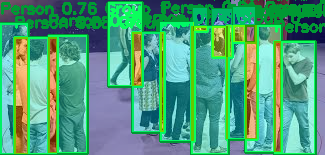

In [35]:
detect_people_and_groups('/content/drive/MyDrive/Colab Notebooks/images (3).jpeg')

# Step 5: Detecting People in Videos

This step involves processing each frame of a video to detect people. The main function detect_people_in_video performs the following:

1. Open the video: Load the video using OpenCV.
2. Process each frame: Detect people in each frame using the process_frame function.
3. Draw bounding boxes: Highlight detected people with bounding boxes.
4. Save the output: Write each processed frame to a new video file.

In [ ]:
from google.colab import files

# Upload image
Vidloaded = files.upload()

# Get the filename of the uploaded image
for vidname in uploaded.keys():
    video_path = vidname


# Step 6: Tracking People Exiting the Frame

In this step, the process_video function tracks the number of people who exit the frame across the video:

1. Track persons: Assign a unique ID to each detected person and track their movement.
2. Count exits: Increment the count when a person exits the frame.
3. Save the result: Overlay the total count on the video and save it.

In [34]:
def process_video(video_path, output_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define the codec and create a VideoWriter object to save the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    total_persons_detected = 0  # Initialize the total count
    person_id = 0  # Unique ID for each person
    person_dict = defaultdict(lambda: {'frame_count': 0, 'last_position': None})  # Track persons

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform person detection
        results = model(frame)

        # Extract detected person count
        detected_persons = []
        for *box, conf, cls in results.xyxy[0].cpu().numpy():
            if int(cls) == 0:  # YOLO class '0' is 'person'
                x_min, y_min, x_max, y_max = map(int, box)
                center_x, center_y = (x_min + x_max) // 2, (y_min + y_max) // 2
                detected_persons.append((center_x, center_y, (x_min, y_min, x_max, y_max)))

        # Track persons
        updated_ids = set()
        for (center_x, center_y, box) in detected_persons:
            matched_id = None
            min_distance = float('inf')

            # Find the closest person from the previous frame
            for pid, info in person_dict.items():
                prev_center = info['last_position']
                distance = np.linalg.norm(np.array([center_x, center_y]) - np.array(prev_center))
                if distance < min_distance:
                    min_distance = distance
                    matched_id = pid

            if matched_id is not None and min_distance < 50:  # Threshold distance
                # Update existing person
                person_dict[matched_id]['last_position'] = (center_x, center_y)
                person_dict[matched_id]['frame_count'] += 1
                updated_ids.add(matched_id)
                x_min, y_min, x_max, y_max = box
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(frame, f'ID: {matched_id}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:
                # New person detected
                person_dict[person_id]['last_position'] = (center_x, center_y)
                person_dict[person_id]['frame_count'] += 1
                updated_ids.add(person_id)
                x_min, y_min, x_max, y_max = box
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(frame, f'ID: {person_id}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                person_id += 1

        # Check for persons who have exited the frame
        for pid in list(person_dict.keys()):
            if pid not in updated_ids:
                total_persons_detected += 1  # Count the person who left the frame
                del person_dict[pid]  # Remove them from tracking

        # Add the person count and total count to the frame
        cv2.putText(frame, f'Total Persons Exited: {total_persons_detected}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        # Save the frame with the count overlay
        out.write(frame)

        frame_count += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    # Return results
    return {
        'total_persons_exited': total_persons_detected,
        'output_path': output_path
    }


In [ ]:
process_video('/content/drive/MyDrive/Colab Notebooks/People Walking Past the Camera - Free Stock Footage For Commercial Projects.mp4', "The_output.mp4" )

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.am

{'total_persons_exited': 387, 'output_path': 'The_output.mp4'}